In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import warnings
warnings.filterwarnings('ignore')

import re
import jax.numpy as jnp
from jax import grad, jit, partial
import ticktack
from ticktack import fitting
from tqdm import tqdm
import scipy
import emcee

rcParams['figure.figsize'] = (8.0, 4.0)

In [41]:
cbm = ticktack.load_presaved_model('Guttler14', production_rate_units = 'atoms/cm^2/s')
cf = fitting.CarbonFitter(cbm)
cf.load_data('example2.csv')
cf.prepare_function(use_control_points=True, interp='gp')

In [42]:
cf.control_points_time

DeviceArray([200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211,
             212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223,
             224, 225, 226, 227, 228, 229], dtype=int64)

In [43]:
# cf.control_points_time = jnp.arange(cf.start, cf.end, 2)
# cf.control_points_time

In [44]:
import inspect
print(inspect.getsource(cf.loss_chi2))

    @partial(jit, static_argnums=(0,))
    def loss_chi2(self, params=()):
        d_14_c = self.dc14(params=params)
        chi2 = jnp.sum(((self.d14c_data[:-1] - d_14_c) / self.d14c_data_error[:-1]) ** 2)
        # chi2 += 10 * jnp.sum(((self.d14c_data[:4] - d_14_c[:4]) / self.d14c_data_error[:4]) ** 2)
        return 0.5*chi2



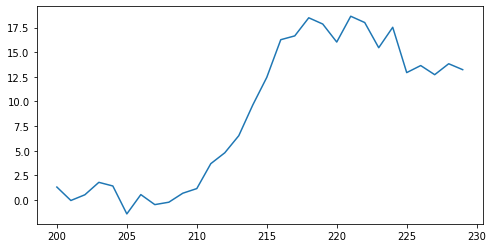

In [45]:
plt.plot(cf.time_data[:-1], cf.d14c_data[:-1])

In [46]:
@jit
def gauss(t):
    prod =  1.87 + 0.7 * 1.87 * jnp.exp(-1/2*((t-215)/3)**2.)
    return prod

In [47]:
cf.offset

DeviceArray(0.90202857, dtype=float64)

In [48]:
cf.offset = 0
cf.offset

0

In [49]:
%%time
soln = cf.fit_cp(low_bound=0.)

CPU times: user 1min 40s, sys: 835 ms, total: 1min 41s
Wall time: 1min 39s


In [50]:
soln.message

'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

In [51]:
print("total likelihood: ", cf.gp_likelihood(soln.x))
print("gp likelihood: ", cf.gp_neg_log_likelihood(soln.x))
print("chi2: ", cf.loss_chi2(soln.x))

total likelihood:  41.112530908287155
gp likelihood:  34.107732255165644
chi2:  7.004798653121509


Text(0.5, 1.0, 'gauss production rate')

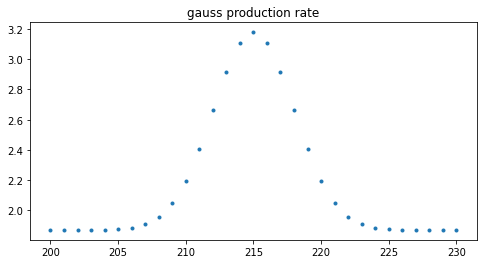

In [52]:
t = cf.control_points_time
t1 = cf.annual
true_cp = gauss(t1)
plt.plot(t1, gauss(t1), ".")
plt.title('gauss production rate')

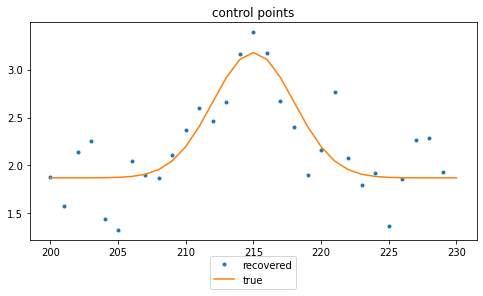

In [53]:
plt.plot(t, soln.x, ".", label="recovered")
plt.plot(t1, true_cp, label='true')
plt.title("control points");
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True)

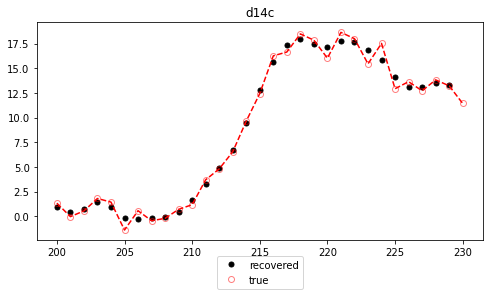

In [54]:
plt.plot(cf.time_data[:-1], cf.dc14(soln.x), ".k", label="recovered", markersize=10)
plt.plot(cf.time_data, cf.d14c_data, '--r')
plt.plot(cf.time_data, cf.d14c_data, 'or', fillstyle="none", label="true", alpha=0.5)
plt.title("d14c");
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True)

In [55]:
soln.x

array([1.8803133 , 1.57506058, 2.13847299, 2.25250451, 1.44181069,
       1.32460411, 2.04503877, 1.89965015, 1.86699486, 2.10716094,
       2.37287691, 2.59930837, 2.45898141, 2.6647954 , 3.16225731,
       3.38999697, 3.17412957, 2.670331  , 2.40480584, 1.90157778,
       2.16129731, 2.76345852, 2.0823472 , 1.79093458, 1.91947241,
       1.36834433, 1.86255467, 2.26695183, 2.28574251, 1.92812096])

In [17]:
print(inspect.getsource(cf.gp_sampling_likelihood))

    @partial(jit, static_argnums=(0,))
    def gp_sampling_likelihood(self, params=()):
        chi2 = self.loss_chi2(params=params)
        return -chi2 + self.gp_log_likelihood(params)



In [18]:
initial = soln.x
burnin, production = 500, 1000
ndim, nwalkers = len(initial), 2*len(initial)
sampler = emcee.EnsembleSampler(nwalkers, ndim, cf.gp_sampling_likelihood)

print("Running burn-in...")
p0 = initial + 1e-5 * np.random.rand(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, burnin, progress=True);

Running burn-in...


100%|█████████████████████████████████████████| 500/500 [03:43<00:00,  2.24it/s]


In [ ]:
print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, production, skip_initial_state_check=True, progress=True);

Running production...


 17%|██████▉                                 | 172/1000 [01:19<06:49,  2.02it/s]